In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

In [2]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [7]:
filter_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210709_indiv_filters'
fly_files = os.listdir(filter_dir)
bbb.sort_nicely(fly_files)
full_files = [os.path.join(filter_dir, file) for file in fly_files]

filters = []
for file in full_files:
    filters.append(np.load(file))

In [8]:
filters[0].shape

(35, 2000, 40)

In [14]:
all_flies = []
for fly in range(len(filters)):
    all_colored_by_betas = []
    for z in range(35):
        colored_by_betas = np.zeros((256*128,40))
        for cluster_num in range(len(np.unique(cluster_model_labels[z+7]))):
            cluster_indicies = np.where(cluster_model_labels[z+7]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = filters[fly][z,cluster_num,:]
        colored_by_betas = colored_by_betas.reshape(256,128,40)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    all_flies.append(all_colored_by_betas)

In [15]:
all_flies[0].shape

(35, 256, 128, 40)

In [29]:
maxs = np.max(all_flies[0][...,20],axis=0)
mins = np.min(all_flies[0][...,20],axis=0)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

In [28]:
maxs.shape, mins.shape

((256, 128), (256, 128))

In [26]:
np.where(np.abs(mins)>maxs)

(array([  5,   6,   6, ..., 238, 238, 238]),
 array([81, 80, 81, ..., 93, 94, 95]))

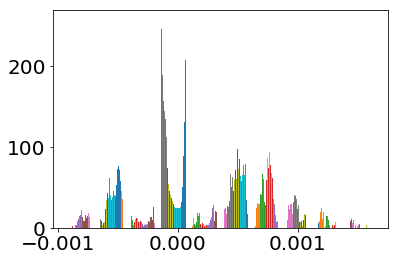

In [31]:
plt.hist(maxs);

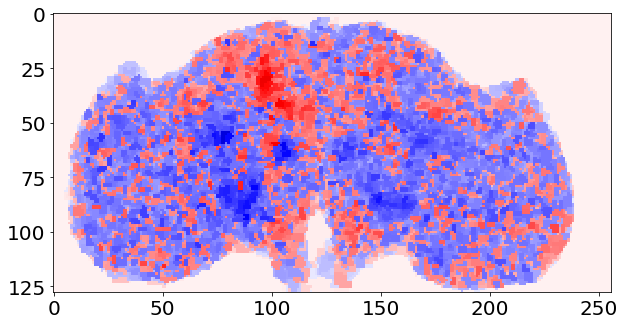

In [38]:
plt.figure(figsize=(10,10))

maxs = np.max(all_flies[0][...,15],axis=0)
mins = np.min(all_flies[0][...,15],axis=0)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]

plt.imshow(maxs.T,cmap='seismic',vmin=-.002,vmax=.002)

In [43]:
# load full model
full_model = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/20210707-034306.npy'
full_model = np.load(full_model)
all_colored_by_betas = []
for z in range(35):
    colored_by_betas = np.zeros((256*128,40))
    for cluster_num in range(len(np.unique(cluster_model_labels[z+7]))):
        cluster_indicies = np.where(cluster_model_labels[z+7]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = full_model[z,cluster_num,:]
    colored_by_betas = colored_by_betas.reshape(256,128,40)
    all_colored_by_betas.append(colored_by_betas)
all_colored_by_betas = np.asarray(all_colored_by_betas)

In [44]:
all_colored_by_betas.shape

(35, 256, 128, 40)

In [52]:
from tqdm import tqdm

In [55]:
corrs = []
for z in tqdm(range(35)):
    for x in range(256):
        for y in range(128):
            means = []
            for n in range(9):
                r, p = scipy.stats.pearsonr(all_flies[n][z,x,y,:], all_colored_by_betas[z,x,y,:])
                means.append(r)
            corrs.append(np.mean(means))

100%|██████████| 35/35 [06:53<00:00, 11.77s/it]


In [77]:
np.save('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210613_aws_filters/invid_corrs', corrs_vol)

In [56]:
corrs = np.asarray(corrs)
corrs.shape

(1146880,)

In [57]:
corrs_vol = np.reshape(corrs,(35,256,128))

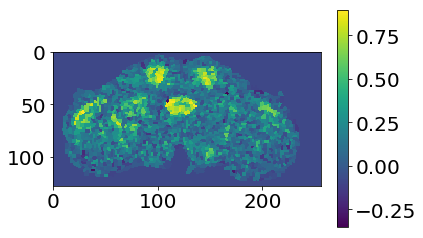

In [76]:
plt.imshow(corrs_vol[12,:,:].T)
plt.colorbar()

100%|██████████| 40/40 [01:24<00:00,  2.62s/it]


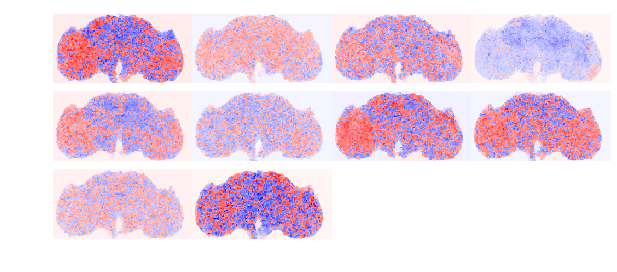

In [53]:
plt.figure(figsize=(10,10))
tp = 20
for tp in tqdm(range(40)):
    for n in range(len(all_flies)+1):
        plt.subplot(3,4,n+1)
        if n < 9:
            maxs = np.max(all_flies[n][...,tp],axis=0)
            mins = np.min(all_flies[n][...,tp],axis=0)
            maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
            plt.imshow(maxs.T,cmap='seismic',vmin=-.002,vmax=.002)
            plt.axis('off')
        else:
            maxs = np.max(all_colored_by_betas[...,tp],axis=0)
            mins = np.min(all_colored_by_betas[...,tp],axis=0)
            maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
            plt.imshow(maxs.T,cmap='seismic',vmin=-.002,vmax=.002)
            plt.axis('off')
    plt.subplots_adjust(hspace=-.8,wspace=0)
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210711_indiv'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    label = format(tp, '02d')
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

In [50]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210711_indiv'
os.mkdir(save_path)